In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from learning_lidar.utils import vis_utils
import seaborn as sns
from scipy.special import factorial
from scipy.stats import skellam
import scipy.stats as stats
#from math import factorial

# GOAL: Investigating the MLE solution and compare it to previous estimation.
## Case 1:

$\underline{\rm{Let}}$ parameters $\lambda_x>0$, $\lambda_n>0$ be given.
>$\lambda_N$ - represents the BG signal parameter --> is known
>$\lambda_X$ - represents the BS signal parameter --> is unknown, this is the parameter we want to estimate
> In this case both parameters are constant through $s$ measurements, and $\lambda_N$ is known.

$\underline{\rm{Let}}$ $X_1, \cdots, X_s$ be i.i.d ${\rm Poiss}(\lambda_X)$ random variables (r.v.)
$\underline{\rm{Let}}$ $N_1, \cdots, N_s$ be i.i.d  ${\rm Poiss}(\lambda_N)$ r.v.
$\underline{\rm{Assume}}$ $\{X_j\}$ and $\{N_j\}$ are independent $\forall j\in[1,s]$


$\underline{\rm{Define}}$: $Y_j = X_j+N_j$.
> $Y_j$- represents the jth measurement.
> $Y_j\sim{\rm Poiss}(\lambda_X+\lambda_N)$.

$\underline{\rm{Objective}}$: find a good estimate for $\lambda_X$: $\hat{\lambda}_x(Y_1, \cdots, Y_s)=?$


### Bad estimate:
1. $\underline{\rm{Define}}:$ $\hat{\lambda}_x^{bad}(Y_1, \cdots, Y_s)=\frac{1}{s}\sum_{j=1}^{s}({Y_j-\lambda_N})$
2. $\underline{\rm{MSE~of~bad~estimator}}$:
>$\rm{MSE}^{bad} =\mathbb{E}\Big[\big(\hat{\lambda}_x^{bad}- \lambda_x\big)^2\Big] = \mathbb{E}\Big[\big(\frac{1}{s}\sum_{j=1}^{s}({Y_j-\lambda_N})- \lambda_x\big)^2\Big]$
>$=\mathbb{E}\Big[\big(\frac{1}{s}\sum_{j=1}^{s}{Y_j}-\lambda_N- \lambda_x\big)^2\Big]\overset{(*)}{=}\cdots \overset{(**)}{=}\cdots=\frac{1}{s}(\lambda_X+\lambda_N)$
>
>>&nbsp; (*) $Z=\sum_{j=1}^{s}({Y_j)$
>>&nbsp; $\Downarrow$
>>&nbsp;$\overset{(*)}{=} \mathbb{E}\Big[\big(\frac{1}{s}Z-\lambda_N- \lambda_x\big)^2\Big]
=\frac{1}{s^2}\mathbb{E}(Z^2)-\frac{2}{s}(\lambda_N+\lambda_x)\mathbb{E}(Z) + (\lambda_N+\lambda_x)^2\overset{(**)}{=}$
>
>>&nbsp;(**) $Z\sim{\rm Poiss}\big(s(\lambda_X+\lambda_N)\big)$ :
>>>&nbsp;$\mathbb{E}(Z) = s(\lambda_X+\lambda_N)$
>>>&nbsp;$\rm{Var}(Z) = s(\lambda_X+\lambda_N)= \mathbb{E}(Z^2)- \mathbb{E}(Z)^2$
>>>&nbsp;$\mathbb{E}(Z^2) = \rm{Var}(Z)+\mathbb{E}(Z)^2=s(\lambda_X+\lambda_N)+s^2(\lambda_X+\lambda_N)^2$
>>
>>&nbsp; $\Downarrow$
>>&nbsp;$\overset{(**)}{=}\frac{1}{s^2}\big[s(\lambda_X+\lambda_N)+s^2(\lambda_X+\lambda_N)^2\big]-\frac{2}{s}(\lambda_N+\lambda_x)\big[s(\lambda_X+\lambda_N) \big] + (\lambda_N+\lambda_x)^2=$
>>$\quad=\frac{1}{s}(\lambda_X+\lambda_N)+ {(\lambda_X+\lambda_N)^2}-2(\lambda_N+\lambda_x)^2 + (\lambda_N+\lambda_x)^2=\frac{1}{s}(\lambda_X+\lambda_N)$

**Conclusion**: The error decreases as the number of samples increases.

In [2]:
import scipy.stats as stats

def mse_noise(mun_,n_,mpt_):
    return mun_/(n_*mpt_)

def mse_bad(mux_,mun_,n_):
    return (mux_+mun_)/n_

def mse_good(mux_,mun_,n_):
    part1 = np.array([mse_bad(mu_x_i,mu_n,n) for mu_x_i in mux_])

    # Part 2 - summarizes the errors of mu_tilde<0
    part2 = np.zeros_like(mux_)
    floor_val, mod = divmod(mun_*n_,1)
    ub = floor_val if mod>0 else floor_val-1
    # print(floor_val, mod,ub)
    def f_k(k,n_):
        # print(k)
        return (k**2)/(n_**2)

    for ii, mu_x_i in enumerate(mux_):
        G_ii = stats.poisson(n*(mu_x_i+mun_))
        part2[ii] = G_ii.dist.expect(lambda k: +f_k(k,n_)#(k**2)/(n**2)
                                               -2*part1[ii]*k
                                               +2*mun_*mu_x_i+mun_**2,
                                      G_ii.args, lb=0, ub=ub,chunksize=10000)
    return part1-part2

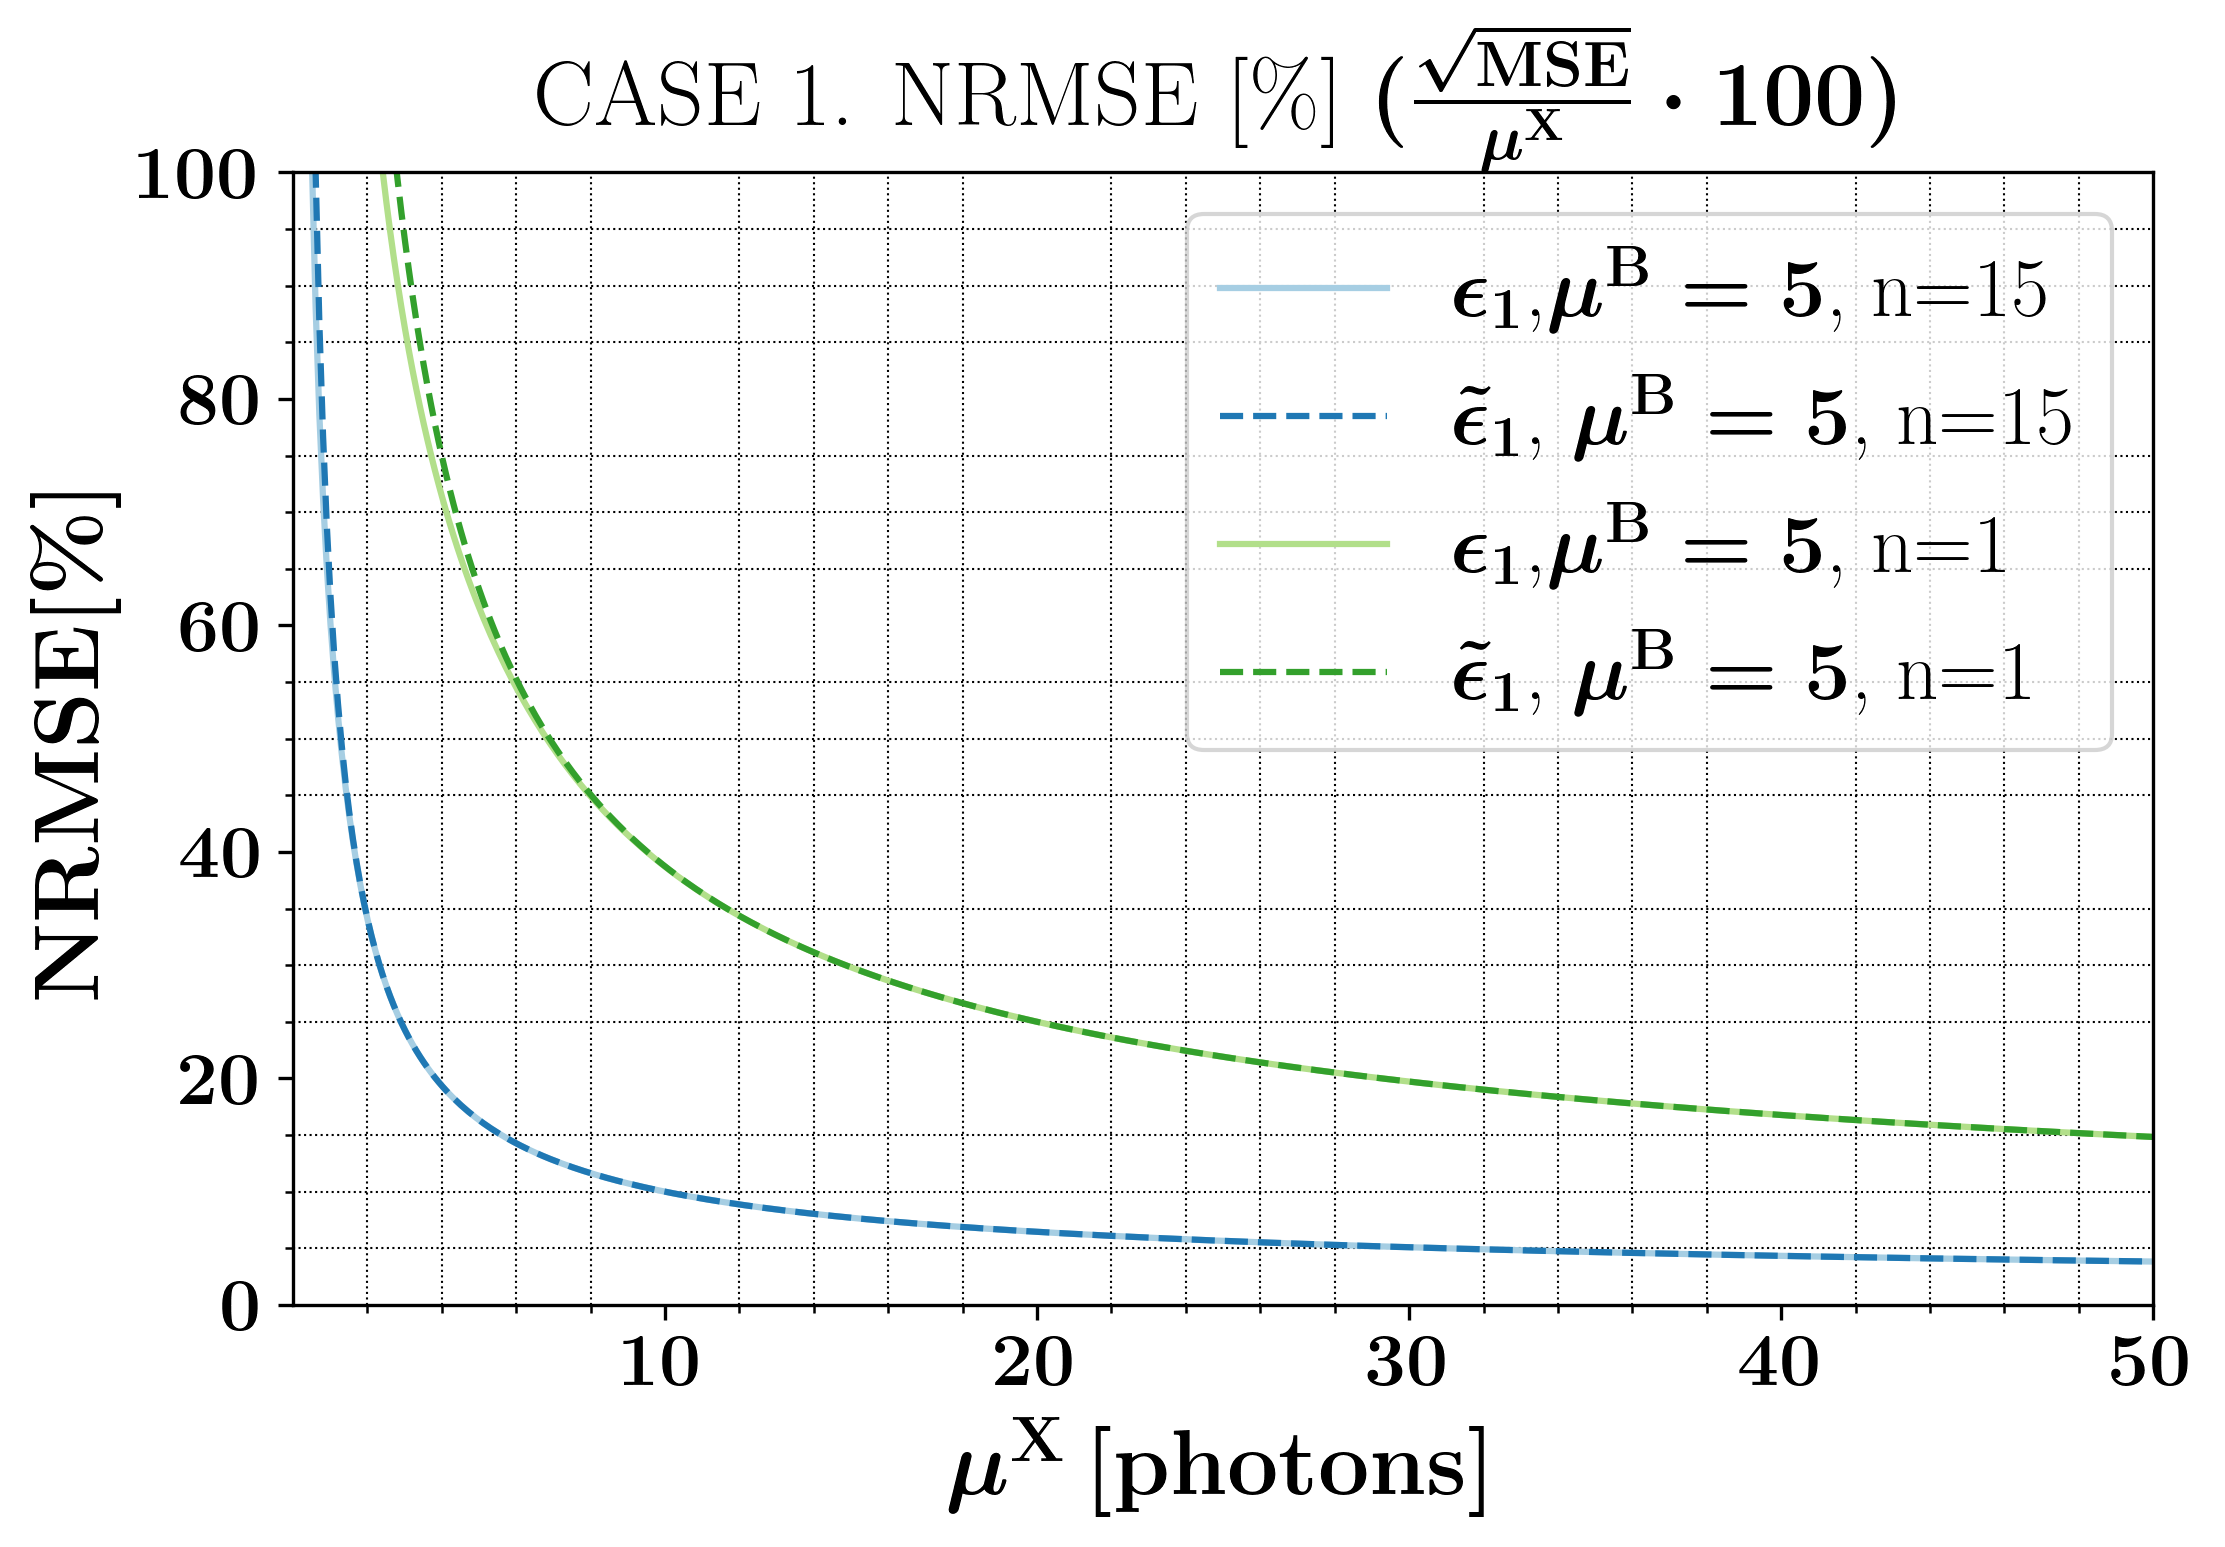

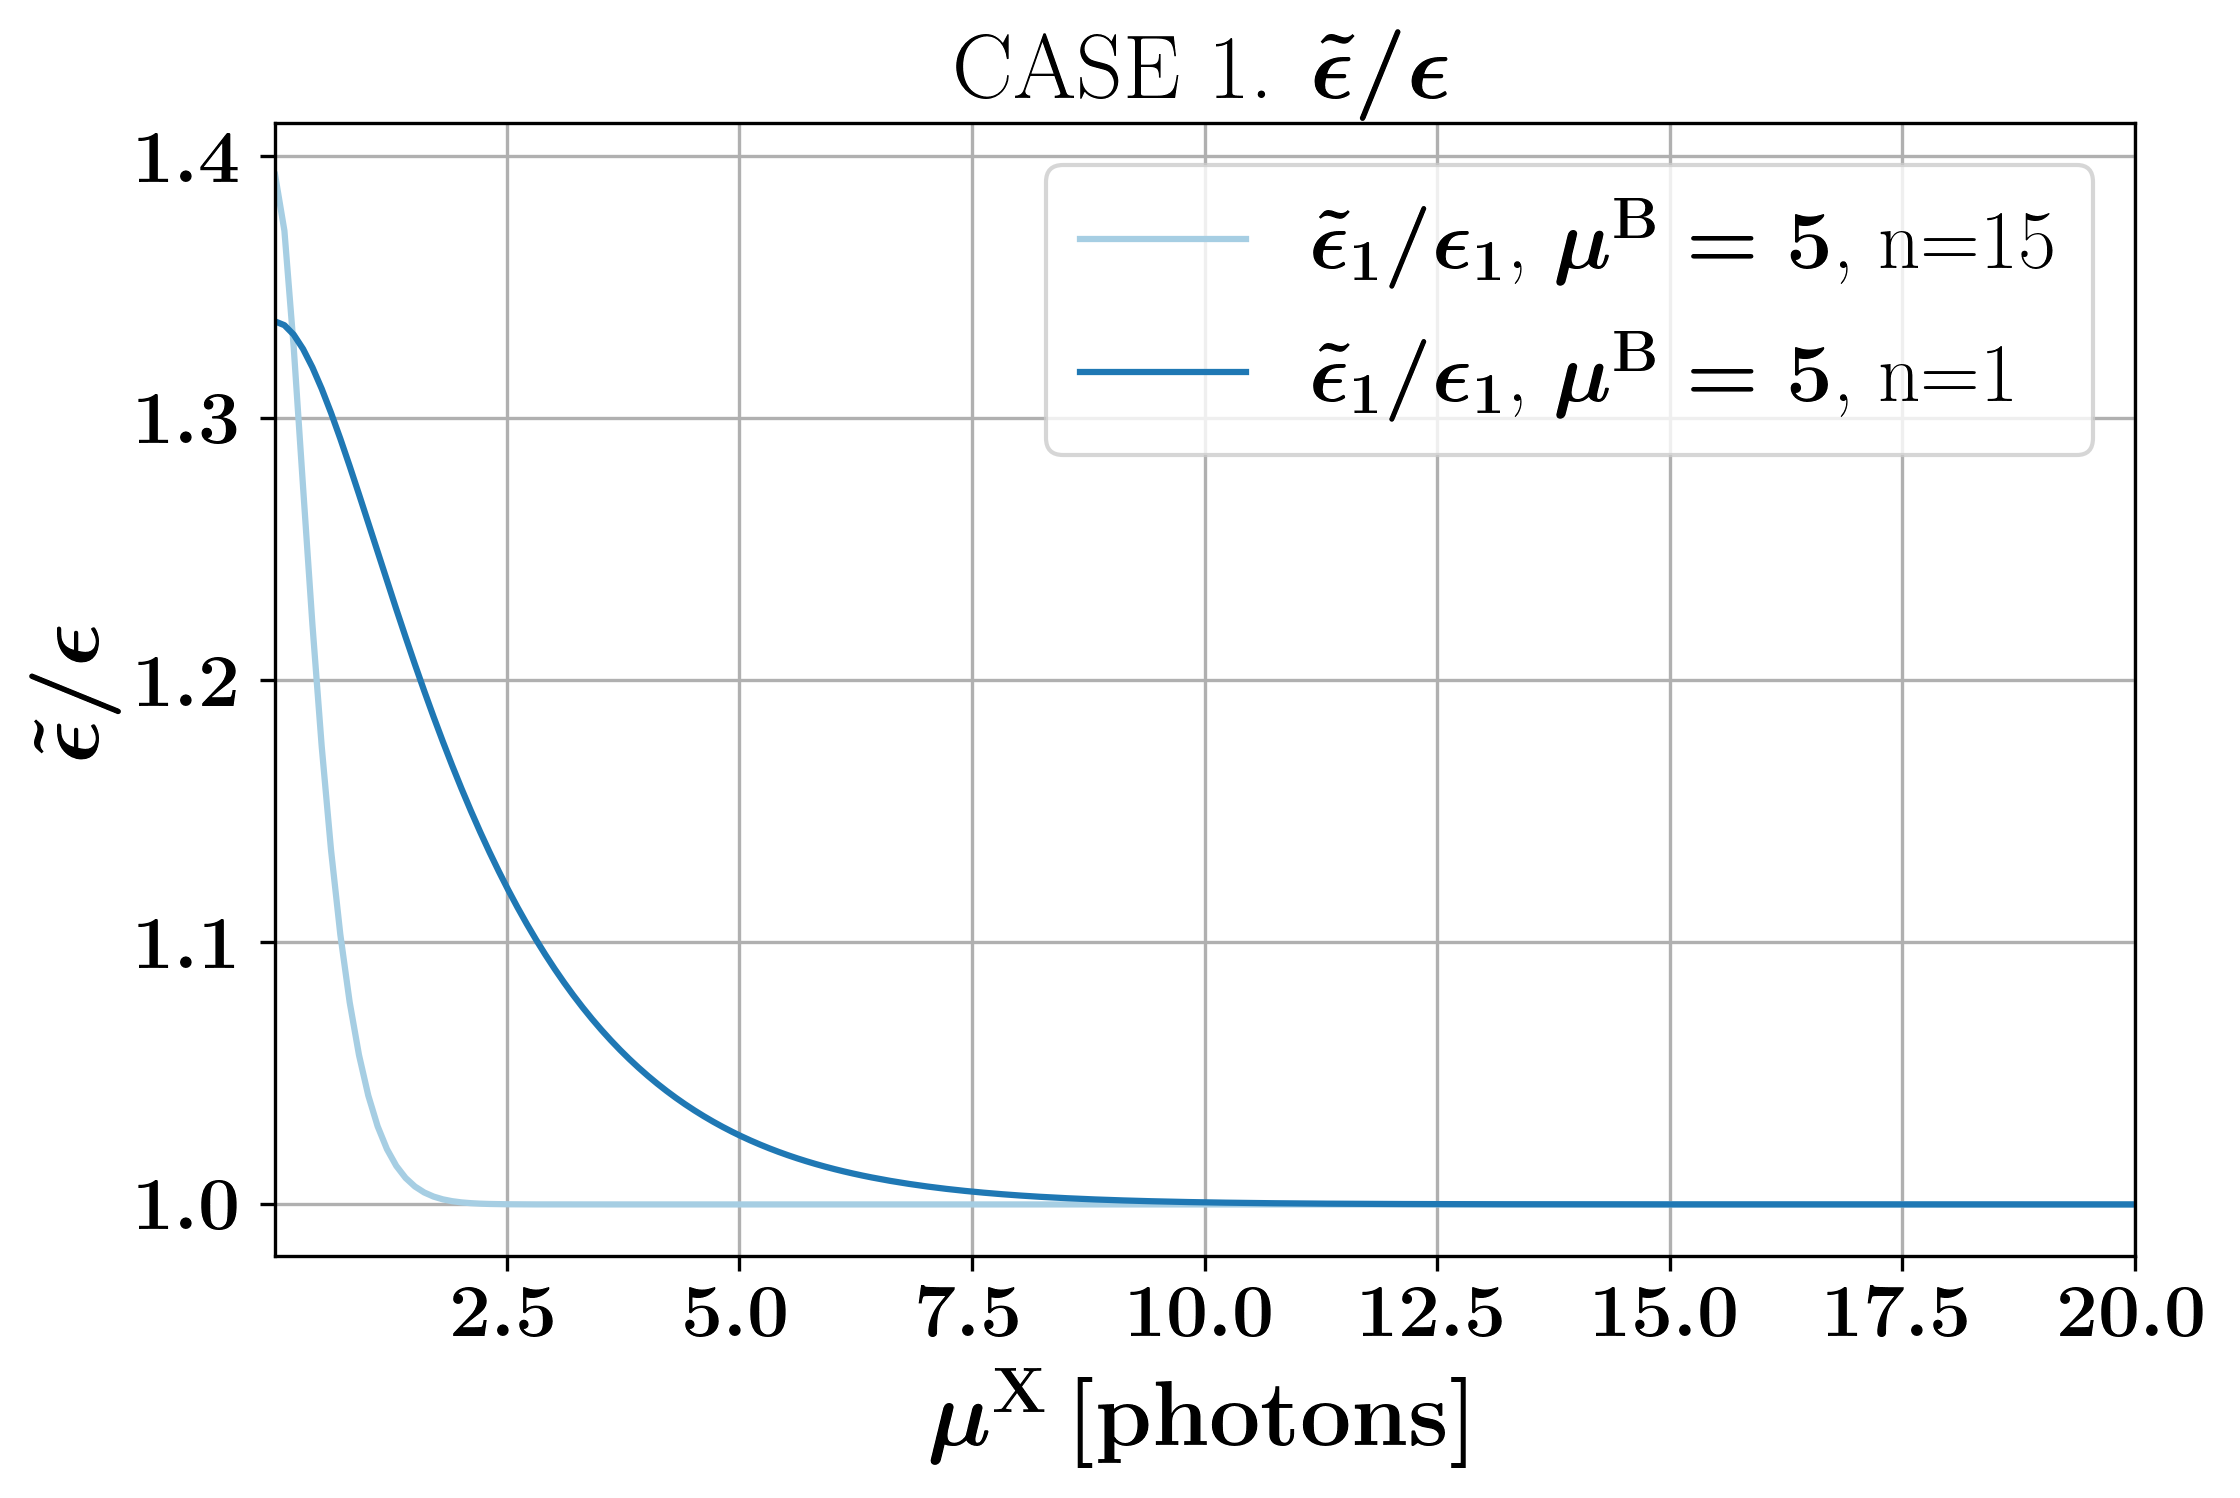

In [36]:
vis_utils.set_visualization_settings()
sns.set_palette(sns.color_palette('Paired'))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), sharey=True)
ax = axes#.ravel()

fig_diff, axes_diff = plt.subplots(nrows=1, ncols=1, figsize=(8,5), sharey=True)
ax_diff = axes_diff
mu_x = np.linspace(0.01,50,num=500)
for n in [15,1]:
    for mu_n in [5]:
        err_bg = mse_noise(mu_n,n,1)
        err_good = mse_good(mu_x,mu_n,n)
        err_old =mse_bad(mu_x,mu_n,n)
        nmrse_good = 100*np.sqrt((err_good))/(mu_x)
        nmrse_old = 100*np.sqrt((err_old))/(mu_x)
        ax.plot(mu_x,nmrse_good, label= fr'$\epsilon_1$,$\mu^{{\rm B}} = {mu_n}$, n={n}')
        ax.plot(mu_x,nmrse_old,  label= fr'$\tilde{{\epsilon}}_1$, $\mu^{{\rm B}} = {mu_n}$, n={n}', linestyle='dashed')
        ax_diff.plot(mu_x,nmrse_old/nmrse_good,  label= fr'$\tilde{{\epsilon}}_1/\epsilon_1$, $\mu^{{\rm B}} = {mu_n}$, n={n}')#, linestyle='dashed')
ax.set_xlabel(r'$\mu^{\rm X}\,[\rm photons]$')
ax.set_ylabel(r'$\rm NRMSE [\%]$')
ax.set_xlim([mu_x[0],mu_x[-1]])#mu_x[-1]])#mu_x[-1]])
ax.set_ylim([0,100])
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.yscale('symlog')
ax.legend()
ax.set_title(r'CASE 1. {\rm NRMSE [\%]}  $\Bigg(\frac{\sqrt{{\rm MSE}}}{\mu^{{\rm X}}}\cdot 100\Bigg)$')

ax_diff.set_title(r'CASE 1. $\tilde{{\epsilon}}/\epsilon$')
ax_diff.set_xlabel(r'$\mu^{\rm X}\,[\rm photons]$')
ax_diff.set_ylabel(r'$\tilde{{\epsilon}}/\epsilon$')
ax_diff.legend()
ax_diff.set_xlim([mu_x[0],20])
plt.grid(which='both')

plt.show()

In [47]:
path = vis_utils.save_fig(fig, fig_name='mse1')
path_diff = vis_utils.save_fig(fig_diff, fig_name='mse1_diff')
path,path_diff

('c:\\users\\addalin\\dropbox\\lidar\\pyalidan\\figures\\mse1.png',
 'c:\\users\\addalin\\dropbox\\lidar\\pyalidan\\figures\\mse1_diff.png')

## Case 2

In [29]:
def f_SW(s,w,mux_,n_,mpt_):
    diff = s/n_ - w/(n_*mpt_)
    val = diff**2-2*mux_*diff
    return val

def f_W(w,n_,mpt_,mux_,mun_):
    # f_W using Z:
    # muz_ = mpt_*n_*(mux_+mun_)
    # G_z = stats.poisson(muz_)

    # ub=w
    #print(ub)
    # chunksize=max(ub,10000)
    # maxcount =chunksize
    # fw = G_z.dist.expect(lambda z: f_ZW(z,w,mux_,n_,mpt_),
    #                                   G_z.args, lb=0, ub=ub,chunksize=chunksize,maxcount=maxcount, tolerance=1e-13)

    # f_W using S:
    mus_ = n_*(mux_+mun_)
    G_s = stats.poisson(mus_)
    floor_val, mod = divmod(w,mpt_)
    ub = floor_val if mod>0 else floor_val-1
    # print(w, floor_val, mod, ub)
    chunksize=max(ub,10000)
    maxcount =chunksize
    fw = G_s.dist.expect(lambda s: f_SW(s,w,mux_,n_,mpt_),
                                      G_s.args, lb=0, ub=ub,chunksize=chunksize,maxcount=maxcount, tolerance=1e-15)
    return fw

def get_f_W(w,n_,mpt_,mux_,mun_):
    # since scipy sends chunks of values, then calculating f_W(w) per value and return a chunk of values
    # print(type(w))
    if type(w)==list or type(w)==np.ndarray:
        res=[f_W(w_ii,n_,mpt_,mux_,mun_) for w_ii in w]
    else:
        res = f_W(w,n_,mpt_,mux_,mun_)
    return res

def mse_2_tilde(mux_,mun_,n_,mpt_):
    return (mux_+mun_)/n_ + mun_/(n_*mpt_)

def mse2(mux_,mun_,n_,mpt_):
    muw_ = n_*mpt_*mun_
    G_w = stats.poisson(muw_)
    err_minuses = G_w.dist.expect(lambda w: get_f_W(w,n_,mpt_,mux_,mun_), G_w.args, lb=0,chunksize=10000,tolerance=1e-15)

    epsilon_tilde = mse_2_tilde(mux_=mux_,mun_=mun_,n_=n_, mpt_=mpt_)

    return epsilon_tilde - err_minuses, err_minuses

Show error for $\mu_x\in[0,20]$

C:\Users\addalin\.conda\envs\lidar_local_new\lib\site-packages\scipy\stats\_distn_infrastructure.py:3595: RuntimeWarning: expect(): sum did not converge
  warnings.warn('expect(): sum did not converge', RuntimeWarning)
C:\Users\addalin\.conda\envs\lidar_local_new\lib\site-packages\scipy\stats\_distn_infrastructure.py:3606: RuntimeWarning: expect(): sum did not converge
  warnings.warn('expect(): sum did not converge', RuntimeWarning)
C:\Users\addalin\.conda\envs\lidar_local_new\lib\site-packages\scipy\stats\_distn_infrastructure.py:3595: RuntimeWarning: expect(): sum did not converge
  warnings.warn('expect(): sum did not converge', RuntimeWarning)


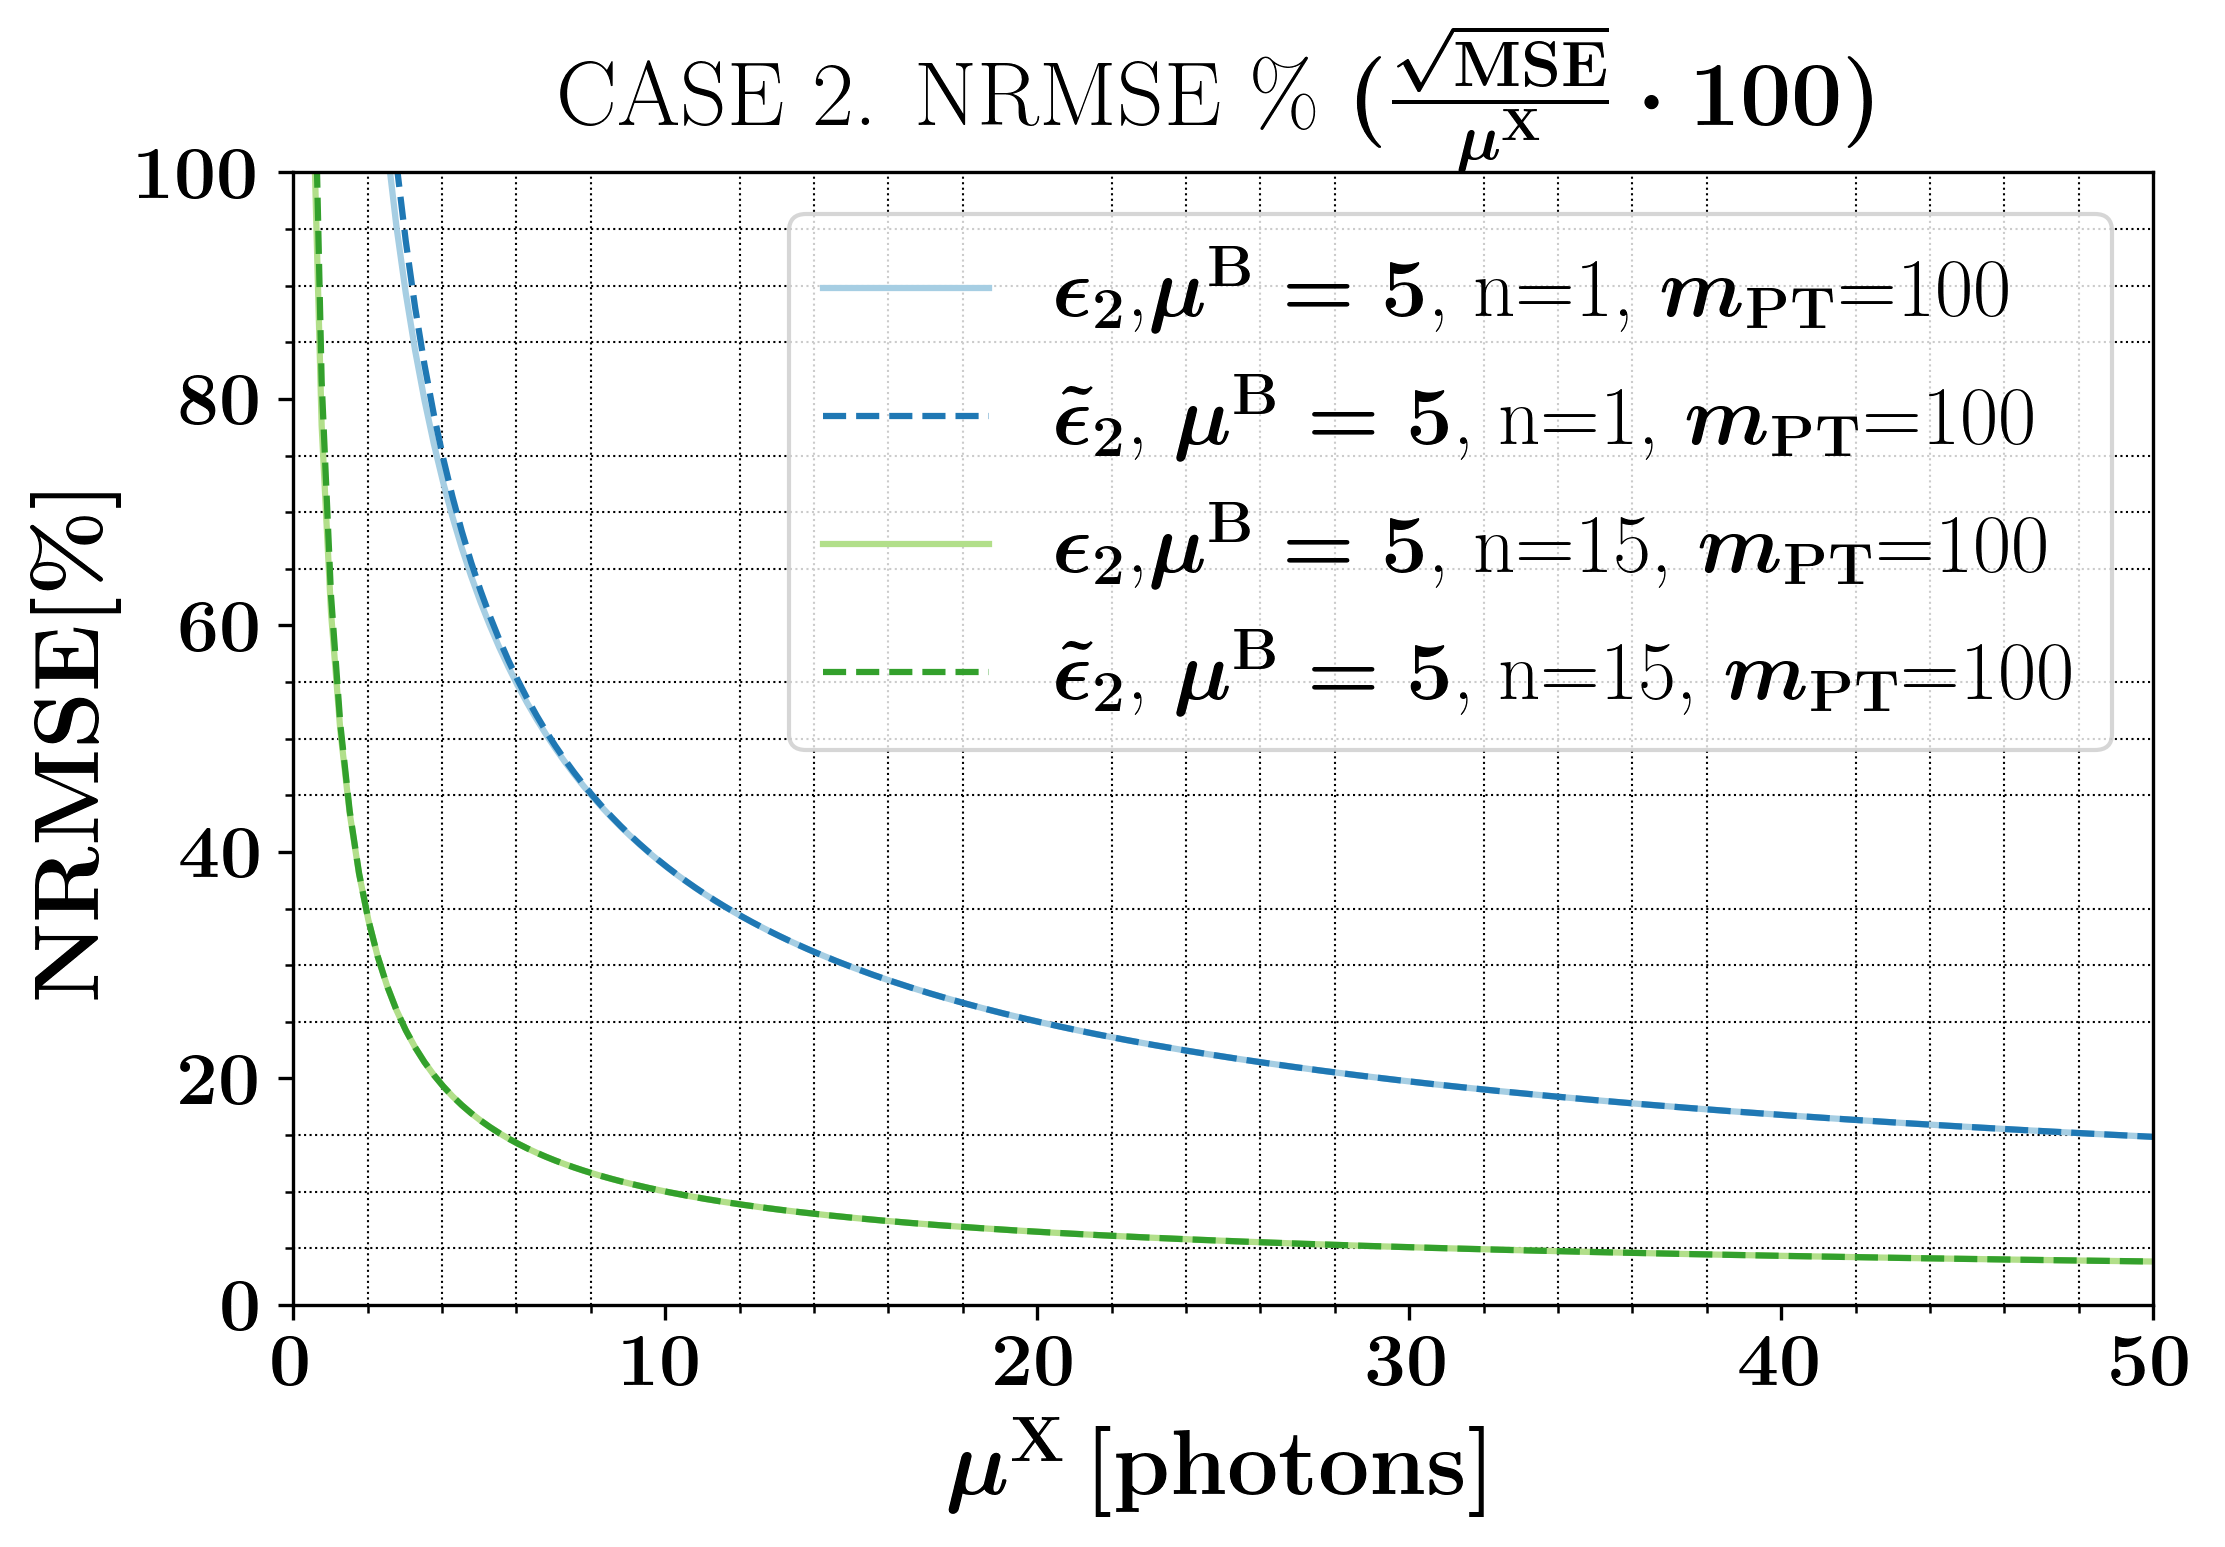

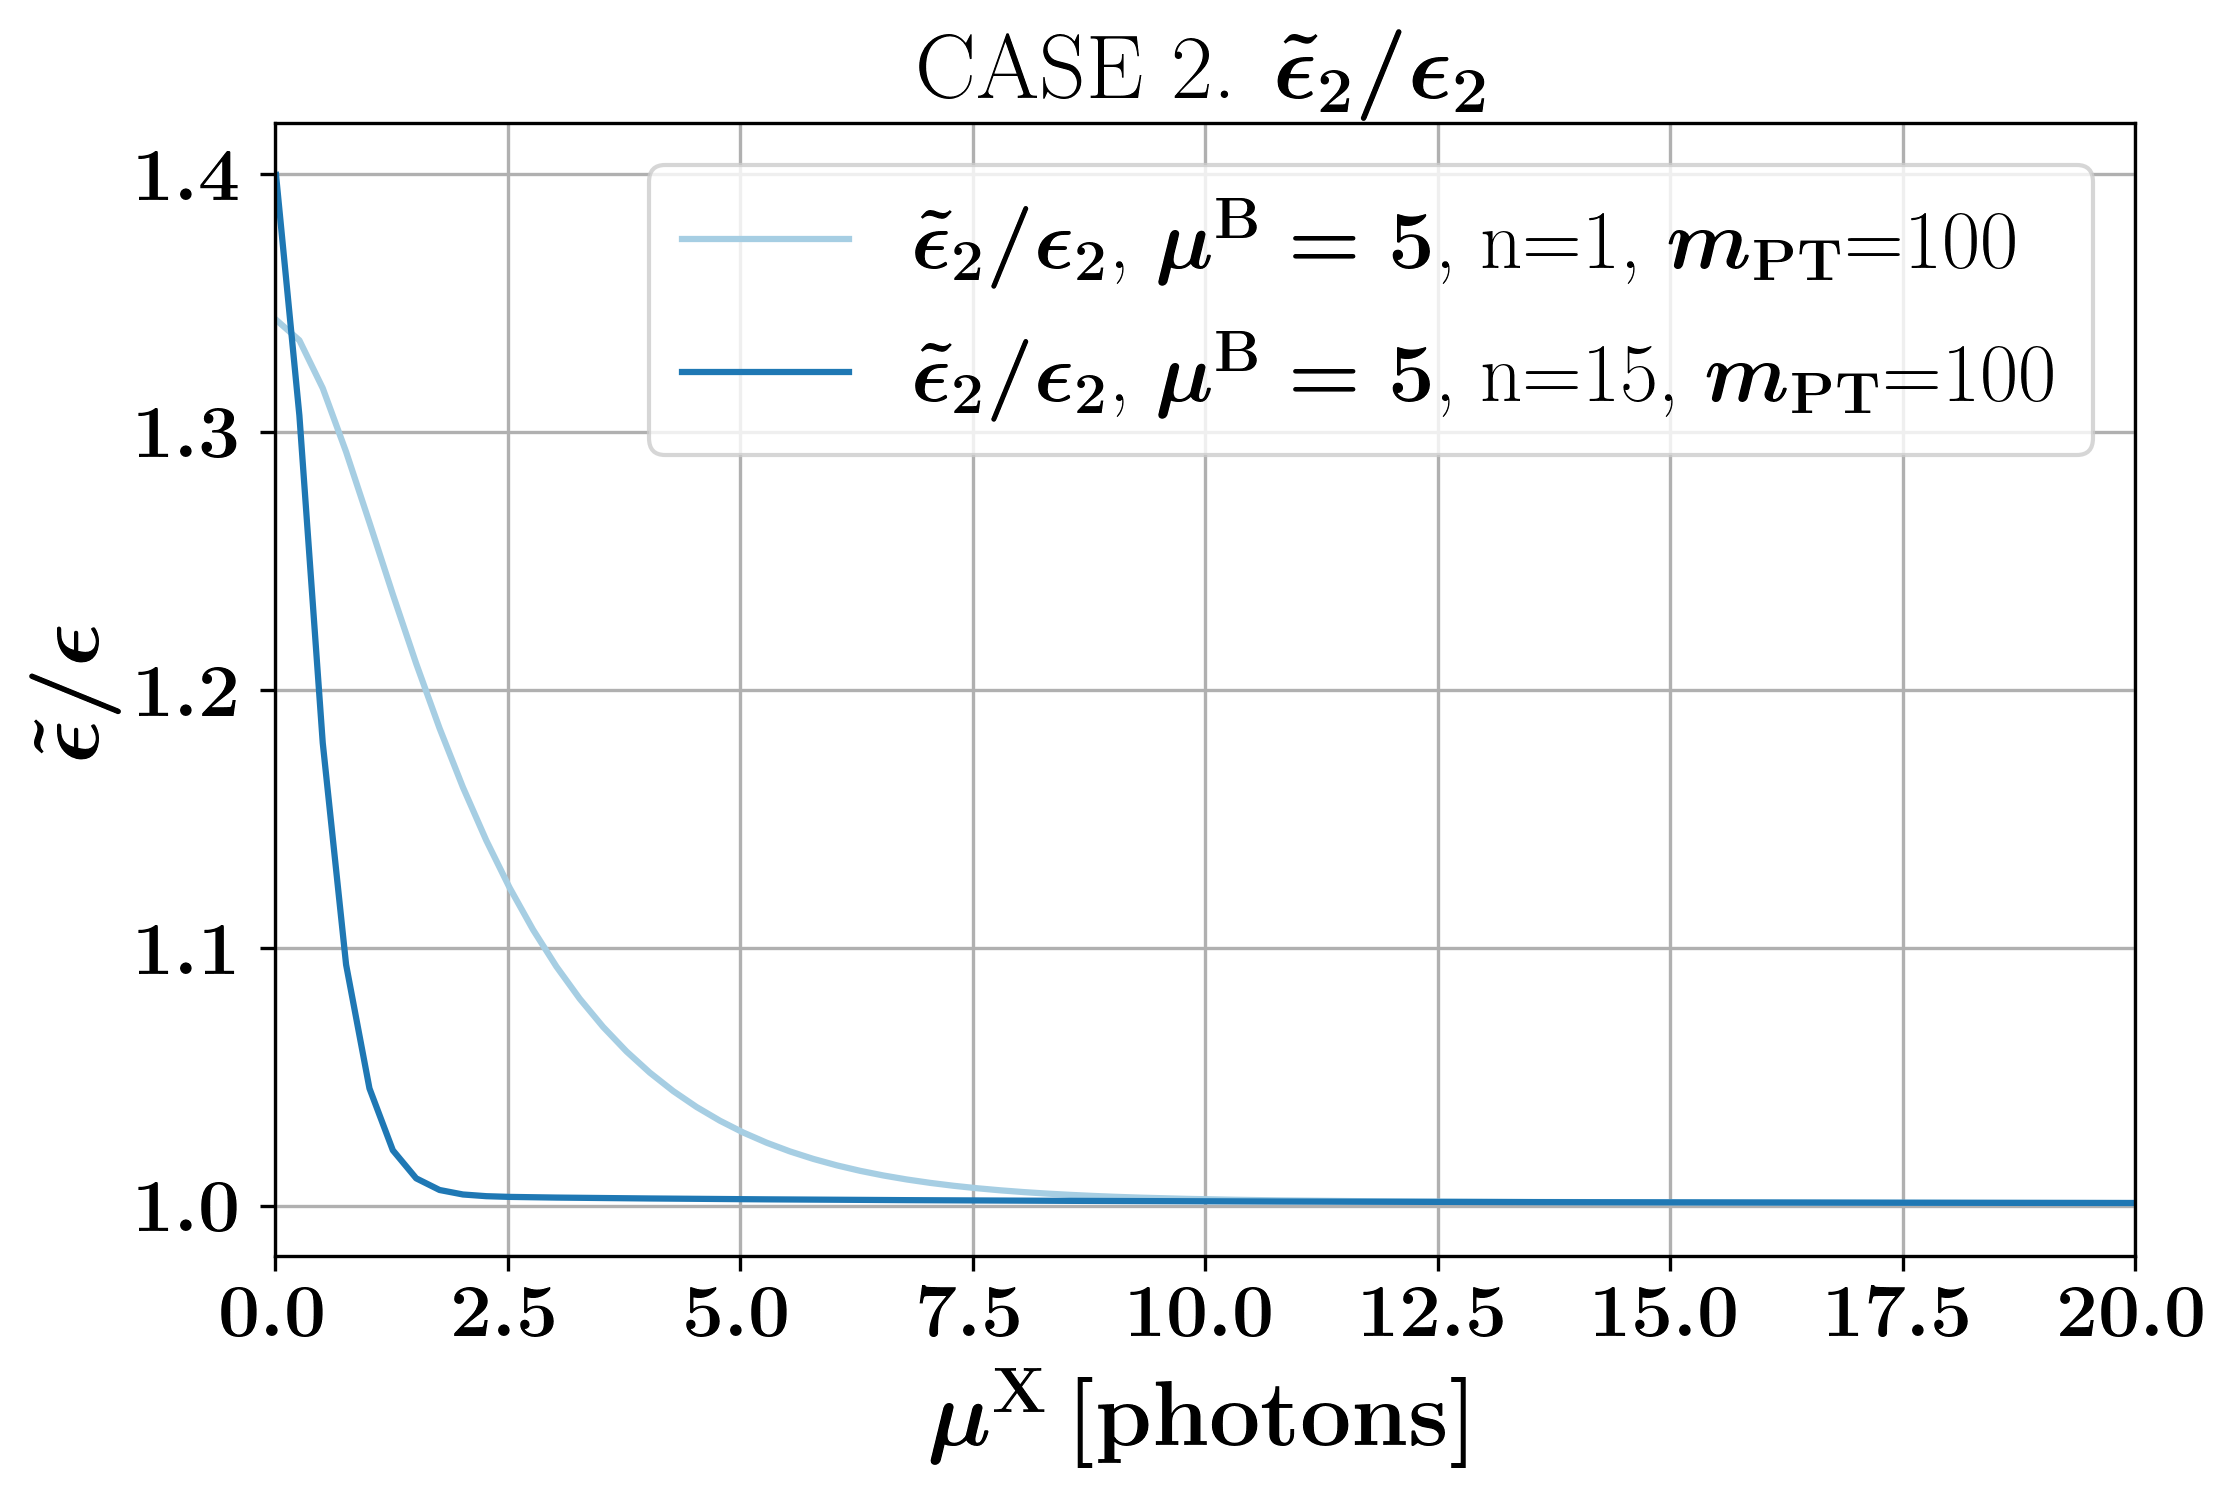

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), sharey=True)
ax = axes
fig_diff, axes_diff = plt.subplots(nrows=1, ncols=1, figsize=(8,5), sharey=True)
ax_diff = axes_diff

mu_xs = np.linspace(0.01,50,num=200)
m_pt = 20
mu_n=5
n_values = [1,15]
# m_values = [100]
m_pt=100
errs= np.zeros((mu_xs.shape[0],len(n_values)))
nmrses = np.zeros_like(errs)
for ii,n in enumerate(n_values):
    err_old =mse_bad(mu_xs,mu_n,n)
    nmrse_old = 100*np.sqrt((err_old))/(mu_xs)
    err_good = mse_good(mu_xs,mu_n,n)
    nmrse_good = 100*np.sqrt((err_good))/(mu_xs)
    # for m_pt in m_values:
    err_old2= [mse_2_tilde(mu_x,mu_n,n, m_pt) for mu_x in mu_xs]
    err_diffs_mle = [mse2(mu_x,mu_n,n, m_pt) for mu_x in mu_xs]
    err_good2 = np.array(err_diffs_mle)[:,0]
    err_minuses = np.array(err_diffs_mle)[:,1]
    nmrse_good2 = 100*np.sqrt((err_good2))/(mu_xs)
    nmrse_old2 = 100*np.sqrt((err_old2))/(mu_xs)
    ax.plot(mu_xs,nmrse_good2, label= fr'$\epsilon_2$,$\mu^{{\rm B}} = {mu_n}$, n={n}, $ m_{{\rm PT}}$={m_pt}')
    ax.plot(mu_xs,nmrse_old2,  label= fr'$\tilde{{\epsilon}}_2$, $\mu^{{\rm B}} = {mu_n}$, n={n}, $ m_{{\rm PT}}$={m_pt}', linestyle='dashed')
    ax_diff.plot(mu_xs,np.array(nmrse_old2)/np.array(nmrse_good),  label= fr'$\tilde{{\epsilon}}_2/\epsilon_2$, $\mu^{{\rm B}} = {mu_n}$, n={n}, $ m_{{\rm PT}}$={m_pt}')
    # save only the errors of the mle since it takes time to calculate them
    errs[:,ii] = err_good2
    nmrses[:,ii] = nmrse_good2
ax.set_title(r'CASE 2. {\rm  NRMSE \%}  $\Bigg(\frac{\sqrt{{\rm MSE}}}{\mu^{{\rm X}}}\cdot 100\Bigg)$')
ax.set_xlabel(r'$\mu^{\rm X}\,[\rm photons]$')
ax.set_ylabel(r'$\rm NRMSE [\%]$')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend()
ax.set_xlim([0,mu_xs[-1]])
ax.set_ylim([0,100])


ax_diff.set_title(r'CASE 2. $\tilde{{\epsilon}}_2/\epsilon_2$')
ax_diff.set_xlabel(r'$\mu^{\rm X}\,[\rm photons]$')
ax_diff.set_ylabel(r'$\tilde{{\epsilon}}/\epsilon$')
ax_diff.legend()
ax_diff.set_xlim([0,20])

plt.grid(which='both')
plt.show()

In [49]:
path_2 = vis_utils.save_fig(fig, fig_name='mse2')
path_diff2 = vis_utils.save_fig(fig_diff, fig_name='mse2_diff')
path_2,path_diff2

('c:\\users\\addalin\\dropbox\\lidar\\pyalidan\\figures\\mse2.png',
 'c:\\users\\addalin\\dropbox\\lidar\\pyalidan\\figures\\mse2_diff.png')

In [46]:
## TODO: save the errors values errs and nmrses for future comarision with m_pth = 250